In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
startdate = '2017-08-01'
enddate = '2017-80-07'
print(calc_temps(startdate, enddate))

[(70.0, 78.82417582417582, 85.0)]


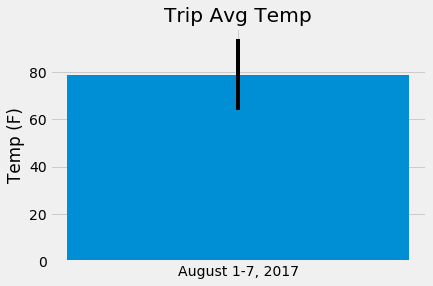

In [11]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tmin = 70.0
tavg = 78.82417582417582
tmax = 85.0
year = 'August 1-7, 2017'
plt.bar(year, tavg, yerr=(tmax-tmin))
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.rcParams['figure.figsize'] = [2, 8]
plt.show()

### Daily Rainfall Average

In [12]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
paststart = dt.date(2017, 8, 1) - dt.timedelta(days=365)
pastend = dt.date(2017, 8, 7) - dt.timedelta(days=365)


# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = func.sum(Measurement.prcp)
totals_prevyear = session.query(sel, Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation).\
        filter(Measurement.station == Station.station).group_by(Measurement.station).\
        filter(Measurement.date >= paststart).filter(Measurement.date <= pastend).order_by(sel.desc()).all()

for record in totals_prevyear:
    (sel, measurement_station, station_name, station_latitude, station_longitude, station_elevation) = record
    print(f"{round(sel, 2)}, {measurement_station}, {station_name}, {station_latitude}, {station_longitude}, {station_elevation}")

6.02, USC00519281, WAIHEE 837.5, HI US, 21.45167, -157.84888999999998, 32.9
4.65, USC00516128, MANOA LYON ARBO 785.2, HI US, 21.3331, -157.8025, 152.4
3.59, USC00513117, KANEOHE 838.1, HI US, 21.4234, -157.8015, 14.6
1.3, USC00519523, WAIMANALO EXPERIMENTAL FARM, HI US, 21.33556, -157.71139, 19.5
1.03, USC00514830, KUALOA RANCH HEADQUARTERS 886.9, HI US, 21.5213, -157.8374, 7.0
0.57, USC00519397, WAIKIKI 717.2, HI US, 21.2716, -157.8168, 3.0
0.18, USC00517948, PEARL CITY, HI US, 21.3934, -157.9751, 11.9


In [13]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [14]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
dates = pd.date_range(start=start_date,end=end_date)

# Strip off the year and save a list of strings in the format %m-%d
days = dates.strftime("%m-%d")

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = []
for day in days:
    data = daily_normals(day)
    normals.append(data[0])
normals

[(67.0, 75.54, 83.0),
 (68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.15686274509804, 83.0)]

In [15]:
days

Index(['08-01', '08-02', '08-03', '08-04', '08-05', '08-06', '08-07'], dtype='object')

In [16]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normal_df = pd.DataFrame(normals, columns = ["TMin", "TAvg", "TMax"], index = days,)
normal_df

,TMin,TAvg,TMax
08-01,67.0,75.540000,83.0
08-02,68.0,75.603774,84.0
08-03,70.0,76.611111,85.0
08-04,69.0,76.711538,84.0
08-05,69.0,76.148148,82.0
08-06,67.0,76.250000,83.0
08-07,71.0,77.156863,83.0


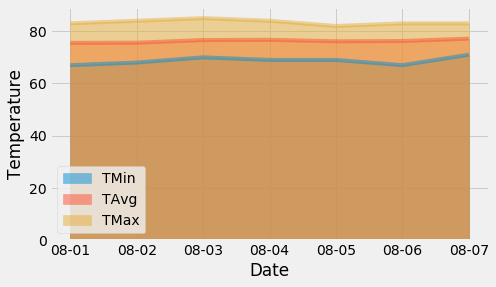

In [19]:
# Plot the daily normals as an area plot with `stacked=False`
normal_df.plot.area(stacked=False)
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.rcParams['figure.figsize'] = [5, 6]
plt.show()

## Close Session

In [18]:
# Close Session
session.close()